## This is the second file for the "Using Air Pollution..." project. It analyzes the panel created in the first notebook labeled "Data_Cleaning"

### 1. Import packages

In [1]:
import pandas as pd
import numpy as np
import geopandas
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import mapclassify

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score



### 2. Change path to read in panel created in "Data_Cleaning" and Mexico shapefiles

In [2]:
data_path = r"C:\Users\lilac2\Box\ACE592_Pollution\Output"
shp_path= r"C:\Users\lilac2\Box\ACE592_Pollution\Data"
data_long = pd.read_csv(data_path+"\Data_Final_long.csv")

### 3. Estimate parameters using OLS

In [3]:
#drop columns not needed as features
data_x = data_long.drop(columns = ["year","gva_r", "ADM1_ES","ADM2_ES","ADM2_PCODE"])
#select income as dependent variable
data_y = data_long[["gva_r"]]

# Normalizing data with StandardScaler()
X = StandardScaler().fit_transform(data_x)
y = StandardScaler().fit_transform(data_y)

# Split sample into training, validation, testing:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
# Create a validation set (to use untouched test data for later)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

#OLS
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
ols_pred = reg.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, ols_pred))
r2 = r2_score(y_val, ols_pred)

print("RMSE: {}, r2: {}".format(rmse,r2))

print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f'% np.sqrt(mean_squared_error(y_val, ols_pred)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_val, ols_pred))


RMSE: 0.3993882021544017, r2: -0.014969956208439994
Coefficients: 
 [[ 0.00265022 -0.02585302  0.00549891 -0.02965413 -0.05218936  0.173441
  -0.11447935  0.03127878  0.06840148 -0.38993067  0.17284207 -0.04951635
   0.20625895  0.2519563  -0.18002383  0.08272036 -0.0428757  -0.21684294
   0.19678023  0.21195027 -0.30930549  0.40603461 -0.00836014 -0.26725511
   0.17532921 -0.18856308  0.08041715 -0.14191909 -0.00111456 -0.05767252
  -0.31535302  0.00078582  0.43645427 -0.17068854  0.06334151  0.17839031
  -0.30250132 -0.01517945  0.06613346  0.14413588 -0.00276724  0.14757848
   0.18657327 -0.13915847 -0.15850744  0.12848598 -0.11176244  0.03809919
  -0.1329903  -0.05942928  0.03705476 -0.04937335  0.03882096  0.12916303
  -0.01816775 -0.09670572  0.06819773 -0.01734975  0.12122555  0.08607893
   0.30938856  0.00890558 -0.50385338  0.29293834  0.10267882  0.12614246
  -0.20290763  0.25422864 -0.20329391  0.11224024 -0.15559698 -0.17533354
  -0.23867153  0.43308211  0.55050525  0.15006

### 3. Lasso with Interaction Terms:

In [4]:
# Creating a function for interaction terms for Lasso using Polynomial Features
def interaction_terms(data):
    interaction = PolynomialFeatures(2, interaction_only=True, include_bias=False)
    output = interaction.fit_transform(data)
    c_names = interaction.get_feature_names(data.columns)
    return output,c_names

output, colnames = interaction_terms(data_x)

In [5]:
#create input features including interaction terms
data_X = pd.DataFrame(output, columns= colnames)
data_y = data_long[["gva_r"]]

In [6]:
# Normalizing data with StandardScaler()
X = StandardScaler().fit_transform(data_X)
y = StandardScaler().fit_transform(data_y)

In [7]:
# Split sample into training, validation, testing:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
# Create a validation set (to use untouched test data for later)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [8]:
# Lasso parameter tuning:
def get_cols(alpha):
    lasso_model =Lasso(alpha=alpha)
    lasso_model = lasso_model.fit(y=y_train,X=X_train)   
    coefs = lasso_model.coef_ 
    return coefs!=0

Alpha = np.arange(0,1,0.01)
coef_lists = [list(get_cols(a)) for a in Alpha]

<ipython-input-8-d5b0552af149>:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_model = lasso_model.fit(y=y_train,X=X_train)
C:\Users\lilac2\Anaconda3\envs\ace592\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\lilac2\Anaconda3\envs\ace592\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 324.91815920388524, tolerance: 0.3915875616921497
  model = cd_fast.enet_coordinate_descent(


### 4. Feature Selection based on $\alpha$ parameter

(0.0, 1.0)

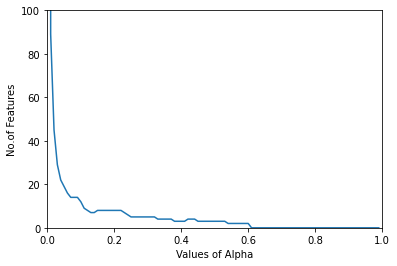

In [9]:
plt.plot(Alpha,pd.DataFrame(coef_lists).sum(axis=1))
plt.ylabel("No.of Features")
plt.xlabel("Values of Alpha")
plt.ylim(0,100)
plt.xlim(0,1)

### 5. Lasso Grid Search with 10-fold cross validation

In [10]:
A = np.arange(.01,0.5,.01)
lasso_model = LassoCV(alphas=A,cv=10)
lasso_model = lasso_model.fit(X_train,y_train)
print("Most optimal value for alpha parameter is:",lasso_model.alpha_)

C:\Users\lilac2\Anaconda3\envs\ace592\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\lilac2\Anaconda3\envs\ace592\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46304043028544584, tolerance: 0.3826743203708265
  model = cd_fast.enet_coordinate_descent(
C:\Users\lilac2\Anaconda3\envs\ace592\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0706225040773916, tolerance: 0.3826743203708265
  model = cd_fast.enet_coordinate_descent(
C:\Users\lilac2\Anaconda3\envs\ace592\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

Most optimal value for alpha parameter is: 0.01


RMSE and r2 values:

In [11]:
y_pred = lasso_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)
print("\nLasso Cross Validation - interaction terms: \nRMSE: {}, r2: {}".format(rmse,r2))

bool_ = lasso_model.coef_!=0

print("Number of features fed into model: {}".format(len(lasso_model.coef_)))
print("Number of features that are non zero:",sum(bool_))
print("\nFeatures that are non zero:\n",data_X.iloc[:,bool_].columns.tolist())


Lasso Cross Validation - interaction terms: 
RMSE: 0.39718784115373473, r2: -0.0038171564842184313
Number of features fed into model: 5778
Number of features that are non zero: 89

Features that are non zero:
 ['max_tmax_06', 'max_tmax_08', 'Shape_Area night_std', 'Shape_Area min_prec_10', 'Shape_Area tpop', 'poll_min max_prec_11', 'poll_min min_prec_10', 'poll_min std_prec_05', 'poll_min std_prec_09', 'poll_min std_prec_11', 'poll_max night_mean', 'poll_max max_prec_09', 'poll_mean night_min', 'night_min night_std', 'night_min max_prec_03', 'night_min mean_prec_01', 'night_min min_prec_02', 'night_min min_prec_04', 'night_min min_prec_06', 'night_min min_prec_07', 'night_min min_prec_11', 'night_min std_prec_02', 'night_min std_prec_04', 'night_min std_prec_05', 'night_min std_prec_07', 'night_min max_tmax_01', 'night_min max_tmax_03', 'night_min mean_tmax_01', 'night_min mean_tmax_03', 'night_min min_tmax_01', 'night_min std_tmax_03', 'night_min std_tmax_11', 'night_max max_prec_09'

### 6. Random Forest:

In [12]:
# Reload data
data_x = data_long.reset_index().drop(columns = ["year","gva_r","ADM1_ES","ADM2_ES","ADM2_PCODE"])
data_y = data_long[["gva_r"]].reset_index()

In [13]:
# Normalizing data with StandardScaler()
X = StandardScaler().fit_transform(data_x)
y = StandardScaler().fit_transform(data_y)

In [14]:
# Redefine X, y for mapping at the later stage
X = pd.DataFrame(X, columns= data_x.columns)
y = pd.DataFrame(y, columns= data_y.columns)
X['index']=data_x.index
y['index']=data_y.index

In [15]:
# Split sample into training, validation, testing:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# Create a validation set (to use test for later)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

# Make copy for mapping at the later stage
X_val_c = X_val.copy()
y_val_c = y_val.copy()

In [16]:
# Drop index in data to avoid including index as feature
X_val = X_val.drop(columns = ['index'])
X_test = X_test.drop(columns = ['index'])
X_train = X_train.drop(columns = ['index'])
y_val = y_val.drop(columns = ['index'])
y_test = y_test.drop(columns = ['index'])
y_train = y_train.drop(columns = ['index'])

### 6.a Without cross validation and default parameters

In [17]:
regr = RandomForestRegressor(random_state=0)
regr.fit(X_train, y_train)
y_pred_test_ran1 = regr.predict(X_val)

<ipython-input-17-6a24934fea6c>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)


#### Predicted vs Actual Scatter Plot


Lasso Cross Validation - interaction terms: 
RMSE: 0.22020637038026142, r2: 0.691452181157513


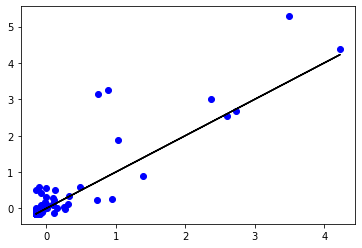

In [18]:
rmse_ran_1 = np.sqrt(mean_squared_error(y_val, y_pred_test_ran1))
r2_ran_1 = r2_score(y_val, y_pred_test_ran1)
print("\nLasso Cross Validation - interaction terms: \nRMSE: {}, r2: {}".format(rmse_ran_1,r2_ran_1))
plt.plot(y_val,y_pred_test_ran1,'o', color = "blue")
plt.plot(y_val,y_val,'k-')

### 6.b Random Forest Cross Validation (n=5) with grid search (Best Model)

In [19]:
#due to computational problems, we set the n_estimators and max_depth at 100
random_grid = {'n_estimators': [100],
               'max_depth': [100],
               'bootstrap': [True,False]}

rf = RandomForestRegressor(random_state = 40)
rf_random = RandomizedSearchCV(rf,random_grid,n_iter=20,n_jobs=-1,random_state=40)

rf_random.fit(X_train,y_train)

C:\Users\lilac2\Anaconda3\envs\ace592\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 2 is smaller than n_iter=20. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\lilac2\Anaconda3\envs\ace592\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(estimator=RandomForestRegressor(random_state=40), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [100],
                                        'n_estimators': [100]},
                   random_state=40)

#### Make a scatterplot of predicted compared to actual income


Random Forest Validation: 
RMSE: 0.21711328094136154, r2: 0.7000592285600662


Text(0, 0.5, 'Predicted Income')

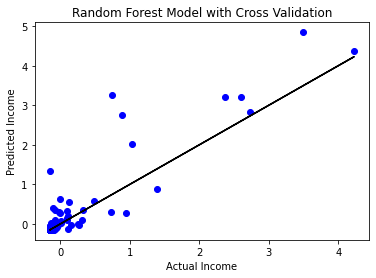

In [20]:
y_pred_rf = rf_random.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_rf))
r2 = r2_score(y_val, y_pred_rf)
print("\nRandom Forest Validation: \nRMSE: {}, r2: {}".format(rmse,r2))
plt.plot(y_val,y_pred_rf,'o', color = "blue")
plt.plot(y_val,y_val,'k-')
plt.title("Random Forest Model with Cross Validation")
plt.xlabel("Actual Income")
plt.ylabel("Predicted Income")


In [21]:
top_params = rf_random.best_params_
best_model = RandomForestRegressor(n_estimators=top_params['n_estimators'],max_depth = top_params['max_depth'], bootstrap = top_params['bootstrap'], random_state = 42)
best_model.fit(X_train, y_train)
importance = best_model.feature_importances_

<ipython-input-21-0cd555696cab>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_model.fit(X_train, y_train)


### 7. Feature selection

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

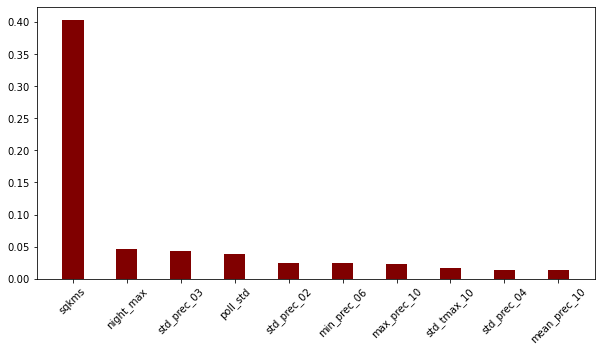

In [22]:
important_features_dict = {}
for idx, val in enumerate(importance):
    important_features_dict[idx] = val

important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)
top_10 = important_features_list[:10]

cols = data_x.columns.to_list()
top10important = []
list_of_top10 = []
for i in top_10:
    top10important.append(cols[i])
    list_of_top10.append(important_features_dict[i])
    
import matplotlib.pyplot as pyplot
# pyplot.barh(list_of_top10)
fig = plt.figure(figsize = (10, 5))
 # creating the bar plot
pyplot.bar(top10important, list_of_top10, color ='maroon',
        width = 0.4)
pyplot.xticks(rotation = 45) 
 

### 8. Map Results Predicted income from Random Forest Best Model and actual income

In [23]:
mex_district_0 = geopandas.read_file(shp_path+r'\boundary_shp\mex_admbnda_adm1_govmex_20200618.shp')
mex_district = geopandas.read_file(shp_path+r'\boundary_shp\mex_admbnda_adm2_govmex_20200618.shp')

In [24]:
# Add predictied value(from RF) and ground truth Y to geodataframe for mapping
X_val_c['y_pred_rf'] = y_pred_rf
X_val_c['y_val'] = y_val

clean4map = pd.merge(data_long.reset_index()[['index','ADM2_PCODE']], X_val_c)

#merge geodataframe with the result(RF prediction)
mex_district = pd.merge(mex_district, clean4map, on='ADM2_PCODE')

In [25]:
#Set centroid as geometry
mex_district['centroid'] = mex_district['geometry'].centroid
mex_district = mex_district.set_geometry('centroid')

<ipython-input-25-bd0eb0d935b9>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mex_district['centroid'] = mex_district['geometry'].centroid


(-119.94927177954999,
 -85.12795580944997,
 13.625896653700064,
 33.627803596300055)

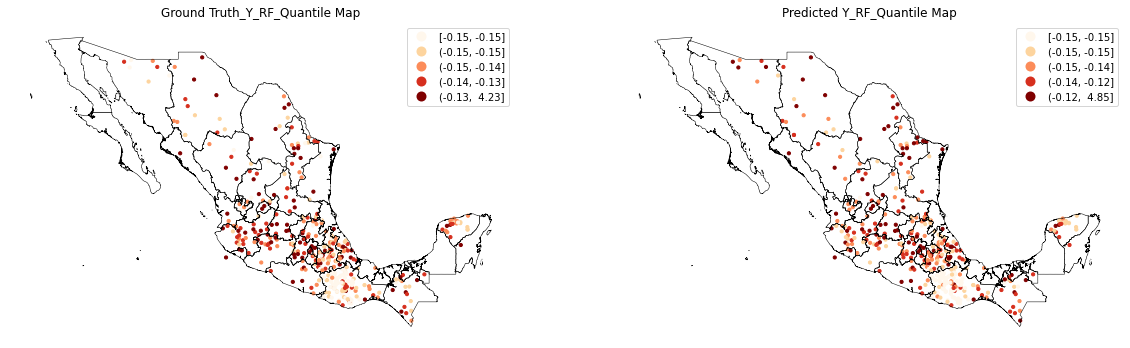

In [26]:
#Plot Maps
fig, ax = plt.subplots(1,2, figsize=(20,10))

mex_district.plot(column='y_val', cmap='OrRd',markersize=10,legend=True,scheme='quantiles',ax=ax[0]);
mex_district_0.plot(ax=ax[0],facecolor='none',edgecolor='black',linewidth=0.5)
ax[0].set_title('Ground Truth_Y_RF_Quantile Map')
ax[0].axis('off')
mex_district.plot(column='y_pred_rf', cmap='OrRd',markersize=10,legend=True,scheme='quantiles',ax=ax[1]);
mex_district_0.plot(ax=ax[1],facecolor='none',edgecolor='black',linewidth=0.5)
ax[1].set_title('Predicted Y_RF_Quantile Map')
ax[1].axis('off')